# 环境导入


In [3]:
# 导入库
import sys
import os

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

cotta_root = os.path.join(project_root, "baseline_code/cotta-main/cifar")
sys.path.append(cotta_root)

plf_root = os.path.join(project_root, "baseline_code/PLF-main/cifar")
sys.path.append(plf_root)


import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import math


from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader

from core_model.train_test import model_test

from core_model.lip_teacher import SimpleLipNet

from configs import settings


import pandas as pd


import cotta
import plf

import torch.optim as optim

from cfgs.conf_cotta import cfg as cfg_cotta
from cfgs.conf_plf import cfg as cfg_plf


from args_paser import parse_args


# sys.argv = ['', '--dataset','cifar-10', '--model', 'cifar-resnet18']
# custom_args = parse_args()
# custom_args

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 通用函数


In [5]:
def setup_cotta(model, args):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """

    def setup_optimizer(params):
        """Set up optimizer for tent adaptation.

        Tent needs an optimizer for test-time entropy minimization.
        In principle, tent could make use of any gradient optimizer.
        In practice, we advise choosing Adam or SGD+momentum.
        For optimization settings, we advise to use the settings from the end of
        trainig, if known, or start with a low learning rate (like 0.001) if not.

        For best results, try tuning the learning rate and batch size.
        """
        if cfg_cotta.OPTIM.METHOD == "Adam":
            return optim.Adam(
                params,
                lr=cfg_cotta.OPTIM.LR,
                betas=(cfg_cotta.OPTIM.BETA, 0.999),
                weight_decay=cfg_cotta.OPTIM.WD,
            )
        elif cfg_cotta.OPTIM.METHOD == "SGD":
            return optim.SGD(
                params,
                lr=cfg_cotta.OPTIM.LR,
                momentum=cfg_cotta.OPTIM.MOMENTUM,
                dampening=cfg_cotta.OPTIM.DAMPENING,
                weight_decay=cfg_cotta.OPTIM.WD,
                nesterov=cfg_cotta.OPTIM.NESTEROV,
            )
        else:
            raise NotImplementedError

    model = cotta.configure_model(model)
    params, param_names = cotta.collect_params(model)
    optimizer = setup_optimizer(params)
    cotta_model = cotta.CoTTA(
        model,
        optimizer,
        args,
        steps=cfg_cotta.OPTIM.STEPS,
        episodic=cfg_cotta.MODEL.EPISODIC,
        mt_alpha=cfg_cotta.OPTIM.MT,
        rst_m=cfg_cotta.OPTIM.RST,
        ap=cfg_cotta.OPTIM.AP,
    )
    return cotta_model


def setup_plf(model, custom_args, num_classes):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """

    def setup_optimizer(params):
        """Set up optimizer for tent adaptation.

        Tent needs an optimizer for test-time entropy minimization.
        In principle, tent could make use of any gradient optimizer.
        In practice, we advise choosing Adam or SGD+momentum.
        For optimization settings, we advise to use the settings from the end of
        trainig, if known, or start with a low learning rate (like 0.001) if not.

        For best results, try tuning the learning rate and batch size.
        """
        if cfg_plf.OPTIM.METHOD == "Adam":
            return optim.Adam(
                params,
                lr=cfg_plf.OPTIM.LR,
                betas=(cfg_plf.OPTIM.BETA, 0.999),
                weight_decay=cfg_plf.OPTIM.WD,
            )
        elif cfg_plf.OPTIM.METHOD == "SGD":
            return optim.SGD(
                params,
                lr=cfg_plf.OPTIM.LR,
                momentum=cfg_plf.OPTIM.MOMENTUM,
                dampening=cfg_plf.OPTIM.DAMPENING,
                weight_decay=cfg_plf.OPTIM.WD,
                nesterov=cfg_plf.OPTIM.NESTEROV,
            )
        else:
            raise NotImplementedError

    model = plf.configure_model(model)
    params, param_names = plf.collect_params(model)
    optimizer = setup_optimizer(params)
    plf_model = plf.PLF(
        model,
        optimizer,
        custom_args,
        steps=cfg_plf.OPTIM.STEPS,
        episodic=cfg_plf.MODEL.EPISODIC,
        mt_alpha=cfg_plf.OPTIM.MT,
        rst_m=cfg_plf.OPTIM.RST,
        ap=cfg_plf.OPTIM.AP,
        num_classes=num_classes,
    )
    return plf_model


def clean_accuracy(
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    batch_size: int = 100,
    device: torch.device = None,
):
    if device is None:
        device = x.device
    acc = 0.0
    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in trange(n_batches):
            x_curr = x[counter * batch_size : (counter + 1) * batch_size].to(device)
            y_curr = y[counter * batch_size : (counter + 1) * batch_size].to(device)

            # print(f'Batch with sample num: {len(x_curr)}')
            output = model(x_curr)
            corrected_num = (output.max(1)[1] == y_curr).float().sum()
            acc += corrected_num

            # [2024-10-10 sunzekun] 屏蔽了结果输出，保持界面整洁
            # print('batch %d, corrected_num: %d' % (counter, corrected_num.item()))
        # save step model_tta
    return acc.item() / x.shape[0]

In [6]:
def get_test_acc(test_loader, model, device):

    # Run-Experiment代码里的评估代码。
    # 只能测试总体的test_acc
    # 放在这里只是为了检查一下错误是不是发生在eva中。实际上可能不用。
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):

    # Run-Experiment代码里的自定义数据集。
    # 放在这里只是为了检查一下错误是不是发生在数据集中。实际上可能不用。

    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]

In [7]:
def get_suffix(method, step):
    # 不同的method有不同的后缀
    # 例如，contra有restore和tta的，我们在综合测评中应该只考虑tta
    # 并且根据step还有所不同。step0的情况下，所有的suffix都为worker_restore.
    # 因此，需要一个函数专门处理各种情况
    # # Step-0

    if step == 0:
        # [24-10-11 sunzekun] 只是为了检测一下contra-teacher的性能临时加的代码
        # if method == 'contra':
        #     return 'teacher_restore'
        # else:
        #     return "worker_restore"
        return "worker_restore"

    # Step-1,2,3
    if method in ["cotta", "plf", "contra"]:
        return "worker_tta"
    else:
        return "worker_restore"

    # ================================================================= #
    # [24-10-14 sunzekun] 单独为ablation-study写的get_suffix
    # 因为区别只是在后缀上精细控制，所以不改eva_系列的函数
    # 仅在该函数中进行手动切换，使用的时候需要特别注意

    # if step == 0:
    #     return "worker_restore"

    # # Step-1,2,3
    # if method == 'contra_tta_only':
    #     return "worker_restore"
    #     # return "worker_tta"
    # else: # method = 'contra'
    #     return "worker_tta"
    #     # return "worker_restore"

In [8]:
def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.2,
    methods=None,
    steps=None,
    results_dir=None,
):
    """
    核心代码，用来评估指定dataset任务下的所有方法的step0~4的测试准确率
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    # core.py中使用的数据集读入代码

    # batch_size = 128

    batch_size = 64

    # PET-37的cotta方法,batch_size要设置的特别小
    # batch_size = 1
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        case,
        None,
        mean,
        std,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
    )

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    #
    # steps = [f'step_{i}' for i in range(4)]
    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"
    assert methods is not None, "请指定评估结果保存的目录"
    os.makedirs(results_dir, exist_ok=True)

    df = pd.DataFrame(index=methods, columns=steps)

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            """
            专为测试lipNet性能的代码
            """
            # model = load_custom_model(model_name, num_classes, load_pretrained=True)
            # features = model.fc.in_features
            # model = nn.Sequential(*list(model.children())[:-1], nn.Flatten())
            # model = SimpleLipNet(model, features, num_classes)
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_teacher_restore.pth'
            # model_repair_save_path = '/nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_teacher_restore.pth'
            # model_repair_save_path = '/nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_worker_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-100/pretrain/step_0/cifar-wideresnet40_teacher_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-100/pretrain/step_0/cifar-wideresnet40_worker_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/pretrain/step_0/wideresnet50_teacher_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/pretrain/step_0/wideresnet50_worker_restore.pth'

            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。
            if method == "cotta" or method == "plf":
                # if (method == 'cotta' or method == 'plf') and dataset_name != 'pet-37':
                # if (method == 'cotta' or method == 'plf') and dataset_name == 'cifar-10':
                # 由于测试代码的jupyternotebook 构建命令行参数很麻烦
                # 这里暂时去掉了dataset，model这两个必选参数的required = True
                # 而是直接在使用的时候复制。
                sys.argv = [
                    "",
                    "--dataset",
                    dataset_name,
                    "--model",
                    model_name,
                    "--uni_name",
                    method,
                    "--noise_type",
                    noise_type,
                    "--balanced",
                ]
                custom_args = parse_args()
                model.eval().to(device)
                if method == "cotta":
                    model_aug = setup_cotta(model, custom_args)
                else:
                    model_aug = setup_plf(model, custom_args, num_classes)

                try:
                    model_aug.reset()
                except:
                    print(f"Failed to reset")

                x_test = torch.from_numpy(test_data)
                y_test = torch.from_numpy(test_labels)
                x_test, y_test = x_test.to(device), y_test.to(device)

                test_acc = clean_accuracy(
                    model_aug, x_test, y_test, batch_size=batch_size, device=device
                )
                # print(test_acc)
            else:
                test_acc = model_test(test_dataloader, model, device=device)
                # print(test_acc)
                test_acc = test_acc["global"]

            print(f"测试集Acc：{test_acc}")
            df.loc[method, step] = test_acc
            # test_acc = get_test_acc(test_dataloader, model, device=device)
            # df.loc[method, step] = test_acc

    # 保留参考代码，万一想用excel保存结果的时候用下面的
    # results_file_name = f'{dataset_name}.xlsx'
    # results_file_dir = os.path.join(results_dir, results_file_name)
    # with pd.ExcelWriter(results_file_dir, engine='openpyxl') as writer:
    #     df.to_excel(writer)
    # for tab, df in dfs.items():

    # cls: 分类任务
    # rtv: 检索任务
    mission_type = "cls" if noise_type == "symmetric" else "rtv"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)

In [9]:
def eva_map(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.2,
    top_k=10,
    methods=None,
    steps=None,
    results_dir=None,
):
    """
    核心代码，用来评估指定dataset任务下的所有方法的step0~4的map，检索任务专用
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # ------------------------------------------------------------------------------------ #
    # 读入测试数据集
    # core.py中使用的数据集读入代码
    # train_data, train_labels, train_dataloader = get_dataset_loader(
    #     dataset_name, "train", case, None, mean, std, batch_size=128, shuffle=False, num_workers=8
    # )

    # test_data, test_labels, test_dataloader = get_dataset_loader(
    #     dataset_name, "test", case, None, mean, std, batch_size=128, shuffle=False, num_workers=8
    # )

    # [24-10-14 数据集存放位置有变化，现在train和test的data已经独立于case了，所以去掉]
    train_data, train_labels, train_dataloader = get_dataset_loader(
        dataset_name,
        "train",
        None,
        None,
        mean,
        std,
        batch_size=128,
        shuffle=False,
        num_workers=8,
    )

    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        None,
        None,
        mean,
        std,
        batch_size=128,
        shuffle=False,
        num_workers=8,
    )

    # ------------------------------------------------------------------------------------ #

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"
    assert methods is not None, "请指定评估结果保存的目录"
    os.makedirs(results_dir, exist_ok=True)

    df = pd.DataFrame(index=methods, columns=steps)

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。

            # [24-10-11 sunzekun] 对于两个带tta的模型，这里不再做单独的增强了，因为增强和检索比较难适配。
            # 直接

            mAP = get_map(model, train_dataloader, test_dataloader, top_k)
            print(f"测试mAP：{mAP}")

            df.loc[method, step] = mAP
            # test_acc = get_test_acc(test_dataloader, model, device=device)
            # df.loc[method, step] = test_acc

    # 保留参考代码，万一想用excel保存结果的时候用下面的
    # results_file_name = f'{dataset_name}.xlsx'
    # results_file_dir = os.path.join(results_dir, results_file_name)
    # with pd.ExcelWriter(results_file_dir, engine='openpyxl') as writer:
    #     df.to_excel(writer)
    # for tab, df in dfs.items():

    # cls: 分类任务
    # rtv: 检索任务
    mission_type = "cls" if noise_type == "symmetric" else "rtv"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)


# 特征提取函数
def extract_features(feature_extractor, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    sim_scores = np.take_along_axis(sims, indices, axis=1)
    return indices, sim_scores


def calculate_map(indices, gallery_labels, query_labels):
    num_queries = query_labels.shape[0]
    ap_list = []
    for i in range(num_queries):
        query_label = query_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        relevant = (retrieved_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    mAP = np.mean(ap_list)
    return mAP


def get_map(model, train_loader, test_loader, top_k):
    model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 提取特征
    g_features, g_labels = extract_features(feature_extractor, train_loader)
    q_features, q_labels = extract_features(feature_extractor, test_loader)
    indices, _ = retrieve(g_features, q_features, top_k=top_k)
    mAP = calculate_map(indices, g_labels, q_labels)

    return mAP

In [10]:
def eva_retrieval(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.2,
    methods=None,
    steps=None,
    top_k=5,
    query_indices=[0],
    use_cache=False,
):
    """
    核心代码，用来展示任意模型的检索结果，检索任务专用
    重要参数：top_k, 用于确定一次输出多少张图片
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    # core.py中使用的数据集读入代码
    # train_data, train_labels, train_dataloader = get_dataset_loader(
    #     dataset_name, "train", case, None, mean, std, batch_size=128, shuffle=False
    # )

    # # TODO-仅用来测试一下数据集的归一化和恢复，以及展示情况
    # # print(train_data[0].shape)
    # # print(train_data[0])
    # # return
    # # img = recover_img(train_data[0], dataset_name)
    # # print(img.max(), img.min())
    # # plt.figure()
    # # plt.imshow(np.transpose(img, (1, 2, 0)))
    # # plt.show()
    # # return

    # test_data, test_labels, test_dataloader = get_dataset_loader(
    #     dataset_name, "test", case, None, mean, std, batch_size=128, shuffle=False
    # )

    train_data, train_labels, train_dataloader = get_dataset_loader(
        dataset_name, "train", None, None, mean, std, batch_size=128, shuffle=False
    )

    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。

            # [24-10-11 sunzekun] 对于两个带tta的模型，这里不再做单独的增强了，因为增强和检索比较难适配。
            # 直接

            cache_path = get_cache_path(
                dataset_name=dataset_name,
                case=case,
                step=step,
                unique_name=method,
                top_k=top_k,
            )
            # print(cache_path)
            # return
            if use_cache:
                try:
                    data = np.load(cache_path)
                except:
                    print(
                        "未读取到对应的相似分数缓存。首次评估某个模型时，请先使用use_cache=False"
                    )
                    continue

                print(f"读取缓存的相似度分数记录：{cache_path}")
                indices = data["indices"]
                sim_scores = data["sim_scores"]
            else:
                indices, sim_scores = get_sim_scores(
                    model, train_dataloader, test_dataloader, top_k
                )
                np.savez(cache_path, indices=indices, sim_scores=sim_scores)
            # print(indices, sim_scores)
            # print(f'Length of retrived indices: {len(indices)}')
            # return
            for query_idx in query_indices:
                print(f"展示Query图片-idx-{query_idx}的搜索结果")
                display_image_grid(
                    test_data,
                    test_labels,
                    train_data,
                    train_labels,
                    query_idx,
                    indices[query_idx],
                    sim_scores[query_idx],
                    save_path=None,  # 如果需要保存图像，设置保存路径
                    dataset_name=dataset_name,  # 用于读取图片的归一化参数，执行‘反归一化’
                )


def get_sim_scores(model, train_loader, test_loader, top_k):
    model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 提取特征
    g_features, g_labels = extract_features(feature_extractor, train_loader)
    q_features, q_labels = extract_features(feature_extractor, test_loader)
    indices, sim_scores = retrieve(g_features, q_features, top_k=top_k)

    return indices, sim_scores


def draw_box(ax, img, color="red"):

    # TODO- Pet37的参数
    # border_width = 6  # 边框的宽度
    # # adjust = border_width /2 + 1
    # adjust = 2

    # TODO- Cifar100的参数
    border_width = 6  # 边框的宽度
    # adjust = border_width /2 + 1
    adjust = 0

    _, height, width = img.shape
    # rect = Rectangle((-adjust + 1 + border_width, -adjust + 1 + border_width), width - 2 * border_width + adjust + 1 , height - 2 * border_width + adjust  + 1 ,
    #                 fill=False, edgecolor=color, linewidth=border_width)
    # rect = Rectangle((-adjust + border_width, -adjust + border_width), width - 2 * border_width + adjust, height - 2 * border_width + adjust,
    #             fill=False, edgecolor=color, linewidth=border_width)

    rect = Rectangle(
        (0, 0),
        width - 1,
        height - 1,
        fill=False,
        edgecolor=color,
        linewidth=border_width,
    )
    ax.add_patch(rect)


box_color = {
    # 'query' : '#FA9248',
    "query": "purple",
    "correct": "#4DA764",
    "wrong": "#E05757",
}


# box_color = {
#     'query' : 'purple',
#     'correct': 'green',
#     'wrong': 'red'
# }


def display_image_grid(
    query_data,
    query_labels,
    gallery_data,
    gallery_labels,
    query_index,
    retrieved_indices,
    sim_scores,
    save_path=None,
    dataset_name=None,
):
    assert dataset_name is not None, "请指明数据集名称，用于恢复对应的归一化后的图片"

    # 读入class_names，用于展示在图片上
    if dataset_name == "cifar-100":
        class_names = load_classes_from_file("../configs/classes/cifar_100_classes.txt")
    elif dataset_name == "pet-37":
        class_names = load_classes_from_file("../configs/classes/pet_37_classes.txt")
    else:
        raise NotImplementedError

    title_fs = 15  # 标题的字号大小

    K = len(retrieved_indices)
    plt.style.use("default")
    fig, axs = plt.subplots(1, K + 1, figsize=(15, 3))
    # 显示查询图像
    query_img = query_data[query_index]
    query_img = recover_img(query_img, dataset_name)

    axs[0].imshow(np.transpose(query_img, (1, 2, 0)))

    query_label = query_labels[query_index]
    query_class_name = class_names[query_label]
    axs[0].set_title(
        query_class_name,
        fontsize=title_fs,
        fontfamily="serif",
        weight="bold",
        color=box_color["query"],
    )
    axs[0].axis("off")

    draw_box(axs[0], query_img, color=box_color["query"])

    print(f"查询图片label：{query_label}-{query_class_name}")

    # 显示检索结果
    for i, idx in enumerate(retrieved_indices):
        img = gallery_data[idx]
        img = recover_img(img, dataset_name)
        axs[i + 1].imshow(np.transpose(img, (1, 2, 0)))

        label = gallery_labels[idx]
        class_name = class_names[label]
        # TODO [24-10-14 sunzekun] 增加相似度分数显示
        class_name = f"{class_name} ({sim_scores[i]:.2f})"

        # axs[i + 1].set_title(class_name, fontsize=title_fs, fontfamily="serif", weight="bold")
        # axs[i + 1].set_title(f"Sim: {sim_scores[i]:.2f}")
        axs[i + 1].axis("off")

        if label == query_label:
            draw_box(axs[i + 1], img, color=box_color["correct"])
            axs[i + 1].set_title(
                class_name,
                fontsize=title_fs,
                fontfamily="serif",
                weight="bold",
                color=box_color["correct"],
            )
        else:
            draw_box(axs[i + 1], img, color=box_color["wrong"])
            axs[i + 1].set_title(
                class_name,
                fontsize=title_fs,
                fontfamily="serif",
                weight="bold",
                color=box_color["wrong"],
            )

    if save_path:
        plt.savefig(save_path)

    plt.gca().set_axis_off()
    plt.subplots_adjust(
        left=0, right=1, top=1, bottom=0, wspace=0.02, hspace=0
    )  # 适配top-5
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.035, hspace=0)  # top-10
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)  # 移除所有边缘空白
    # plt.tight_layout()
    plt.margins(0, 0)
    plt.show()


def recover_img(img, dataset_name):
    if dataset_name == "pet-37":
        means = np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
        stds = np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]
    elif dataset_name == "cifar-100":

        means = np.array([0.5071, 0.4865, 0.4409])[:, np.newaxis, np.newaxis]
        stds = np.array([0.2673, 0.2564, 0.2762])[:, np.newaxis, np.newaxis]
    else:
        raise NotImplementedError
    return np.clip(img * stds + means, 0, 1)


def get_cache_path(dataset_name, case, step, unique_name, top_k):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_main/rtv_cache",
        dataset_name,
        case,
        f"step_{step}",
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"top_{top_k}.npz")


def load_classes_from_file(file_path):
    """从文件中读取类别列表"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [11]:
# PET-37的归一化参数（从gen_pet37的代码里找到）
# import torchvision
# torchvision.models.ResNet18_Weights.DEFAULT.transforms()

## 主实验

### cifar-10-分类


In [12]:
dataset_name = "cifar-10"
model_name = "cifar-resnet18"
noise_type = "symmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ['contra']
# methods = ['JoCoR']
# methods = ['raw']
# methods = ['cotta']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
methods = ["raw", "replay", "Coteaching", "Coteachingplus", "JoCoR", "contra"]
steps = [i for i in range(4)]
# steps = [0]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #

eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

目前测试的数据集：cifar-10, case模式：nr_0.2_nt_symmetric_balanced
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.2_nt_symmetric_balanced/step_0/raw/cifar-resnet18_worker_restore.pth


/tmp/ipykernel_176788/1248627038.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


test_acc: 82.23
label: 0, acc: 87.30
label: 1, acc: 95.40
label: 2, acc: 72.80
label: 3, acc: 59.30
label: 4, acc: 76.50
label: 5, acc: 74.50
label: 6, acc: 88.10
label: 7, acc: 86.30
label: 8, acc: 91.80
label: 9, acc: 90.30
测试集Acc：0.8223
Evaluating /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.2_nt_symmetric_balanced/step_1/raw/cifar-resnet18_worker_restore.pth
test_acc: 81.10
label: 0, acc: 81.90
label: 1, acc: 91.60
label: 2, acc: 71.20
label: 3, acc: 65.90
label: 4, acc: 81.00
label: 5, acc: 73.10
label: 6, acc: 83.50
label: 7, acc: 83.80
label: 8, acc: 89.40
label: 9, acc: 89.60
测试集Acc：0.811
Evaluating /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.2_nt_symmetric_balanced/step_2/raw/cifar-resnet18_worker_restore.pth
test_acc: 80.80
label: 0, acc: 81.80
label: 1, acc: 90.10
label: 2, acc: 72.10
label: 3, acc: 63.40
label: 4, acc: 78.50
label: 5, acc: 69.90
label: 6, acc: 86.40
label: 7, acc: 86.10
label: 8, acc: 90.10
label: 9, acc: 89.60
测试集Acc：0.808
Evaluating /nvme/szh/code/tta-mr/ckpt/ci

### Pet-37 分类

> 评估测试集 acc


In [13]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "symmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ['contra']
# methods = ['raw']
# methods = ['cotta']
# methods = ['plf']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
steps = [i for i in range(4)]
# steps = [0]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #

eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

目前测试的数据集：pet-37, case模式：nr_0.2_nt_symmetric_balanced
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_symmetric_balanced/test_data.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_symmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_176788/1248627038.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


test_acc: 91.25
label: 0, acc: 72.45
label: 1, acc: 93.00
label: 2, acc: 34.00
label: 3, acc: 89.00
label: 4, acc: 97.00
label: 5, acc: 90.00
label: 6, acc: 88.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 83.00
label: 10, acc: 90.00
label: 11, acc: 93.81
label: 12, acc: 96.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 96.00
label: 16, acc: 94.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 99.00
label: 20, acc: 91.00
label: 21, acc: 95.00
label: 22, acc: 98.00
label: 23, acc: 91.00
label: 24, acc: 94.00
label: 25, acc: 99.00
label: 26, acc: 75.00
label: 27, acc: 86.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 98.99
label: 31, acc: 99.00
label: 32, acc: 84.00
label: 33, acc: 95.00
label: 34, acc: 71.91
label: 35, acc: 95.00
label: 36, acc: 100.00
测试集Acc：0.9125102207686018
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_symmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth
test_acc: 88.55
label: 0, acc: 87

KeyboardInterrupt: 

### Cifar-100 检索

> 计算 mAP（test_acc 仅供参考）


In [ ]:
dataset_name = "cifar-100"
model_name = "cifar-wideresnet40"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ['contra']
# methods = ['raw']
# methods = ['cotta']
# methods = ['cotta', 'plf']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'JoCoR', 'cotta', 'contra']

methods = ["cotta", "plf"]
# methods = ['replay', 'contra']
steps = [i for i in range(4)]
# steps = [3]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #
eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

# eva_map(dataset_name, model_name, noise_type,
#         methods=methods, steps=steps, results_dir=results_dir,
#         top_k=30)

> 图片检索


In [ ]:
dataset_name = "cifar-100"
model_name = "cifar-wideresnet40"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""

# methods = ['raw']
# methods = ['Coteaching']
# methods = ['JoCoR']
methods = ["contra"]

# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# steps = [i for i in range(4)]
steps = [3]
# ------------------------------------------------------------- #

"""
检索用参数
"""
top_k = 5
query_indices = [333]
# ------------------------------------------------------------- #
# eva_retrieval(dataset_name, model_name, noise_type,
#               methods=methods, steps=steps,
#               top_k=top_k, query_indices=query_indices)

# 已经测试过一次的时候，用这个：
eva_retrieval(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    top_k=top_k,
    query_indices=query_indices,
    use_cache=True,
)

# 322-flatfish
# 333， 334


# for i in range(331, 340):
#     query_indices = [i]
#     eva_retrieval(dataset_name, model_name, noise_type,
#                 methods=methods, steps=steps,
#                 top_k=top_k, query_indices=query_indices,
#                 use_cache=True)

### Pet-37 检索

> 计算 mAP（test_acc 仅供参考）


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ["contra"]
# methods = ['raw']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# methods = ['cotta', 'plf']
methods = ["cotta"]
# steps = [i for i in range(4)]
# steps = [0]
steps = [1, 2, 3]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #
eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)
# eva_map(
#     dataset_name,
#     model_name,
#     noise_type,
#     methods=methods,
#     steps=steps,
#     results_dir=results_dir,
# )

目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/cotta/wideresnet50_worker_tta.pth


/tmp/ipykernel_252992/4186978523.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
/nvme/sunzekun/Projects/tta-mr/baseline

测试集Acc：0.2221313709457618
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/cotta/wideresnet50_worker_tta.pth


100%|██████████| 58/58 [03:53<00:00,  4.02s/it]


测试集Acc：0.22267647860452439
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/cotta/wideresnet50_worker_tta.pth


100%|██████████| 58/58 [03:50<00:00,  3.97s/it]

测试集Acc：0.22567457072771874


> 图片检索


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
methods = ["contra"]
# methods = ['raw']
# methods = ['Coteaching']
# methods = ['JoCoR']
# methods = ['cotta']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# steps = [i for i in range(4)]
steps = [3]
# ------------------------------------------------------------- #
"""
检索用参数
"""
top_k = 5
# query_indices = [3102] # Shiba Inu
# query_indices = [3102]


# query_indices = [2321] # Perisian
# query_indices = [444] # 币哥
# query_indices = [303] #

query_indices = [321]

# ------------------------------------------------------------- #
# eva_retrieval(dataset_name, model_name, noise_type,
#               methods=methods, steps=steps,
#               top_k=top_k, query_indices=query_indices)

# 已经计算过一次分数的时候，用这个：
eva_retrieval(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    top_k=top_k,
    query_indices=query_indices,
    use_cache=True,
)


# # 303、304
# for i in range(321, 330):
#     query_indices = [i]
#     eva_retrieval(dataset_name, model_name, noise_type,
#                 methods=methods, steps=steps,
#                 top_k=top_k, query_indices=query_indices,
#                 use_cache=True)

# 敏感度实验


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ['raw', 'Coteaching', 'contra']
methods = ["raw", "replay", "Coteaching", "contra"]
steps = [i for i in range(4)]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_sensitivity"
# ------------------------------------------------------------- #


for noise_ratio in [0.1, 0.3, 0.5]:
    # 分类任务评估
    results_dir = f"./results_sensitivity/nr_{noise_ratio}"
    eva_test_acc(
        dataset_name,
        model_name,
        noise_ratio=noise_ratio,
        noise_type="symmetric",
        methods=methods,
        steps=steps,
        results_dir=results_dir,
    )

    # 检测任务评估
    eva_map(
        dataset_name,
        model_name,
        noise_ratio=noise_ratio,
        noise_type="asymmetric",
        methods=methods,
        steps=steps,
        results_dir=results_dir,
    )

> 结果绘图


In [ ]:
def visualize(results_file_path, type="cls"):
    data = pd.read_csv(results_file_path, index_col=0)
    plt.figure(figsize=(4, 4))
    # fig, ax = plt.subplots(figsize=(4, 5))
    ax = plt.gca()
    ax.set_facecolor("#EAEAF2")
    # color_list = ['#696969', '#2799B2', '#4DA764']

    lw = 2
    ms = 10  # marker_size
    tfs = 12  # tick font size

    plt.plot(
        data.columns,
        data.loc["raw"],
        label="raw",
        color="#696969",
        linestyle="--",
        linewidth=lw,
        marker="o",
        markersize=ms,
    )  # Grey dashed line
    plt.plot(
        data.columns,
        data.loc["Coteaching"],
        label="coteaching",
        color="#2799B2",
        linewidth=lw,
        marker="^",
        markersize=ms,
    )  # Blue solid line
    plt.plot(
        data.columns,
        data.loc["contra"],
        label="contra",
        color="#4DA764",
        linewidth=lw,
        marker="s",
        markersize=ms,
    )  # Green solid line
    plt.plot(
        data.columns,
        data.loc["replay"],
        label="raw",
        color="#37D4AD",
        linewidth=lw,
        marker="p",
        markersize=ms,
    )  # Green solid line

    # for i, label in enumerate(data.index):
    #     plt.plot(data.columns, data.loc[label], label=label, color=color_list[i])

    if type == "cls":

        # plt.yticks(np.arange(0.75, 0.96, 0.05), [''] * len(np.arange(0.75, 0.96, 0.05)), fontsize=tfs, rotation=90, va='center', fontfamily="serif", weight="bold")
        # plt.yticks(np.arange(0.25, 0.95, 0.2), fontsize=tfs, rotation=90, va='center', fontfamily="serif", weight="bold")
        plt.yticks(
            np.arange(0.80, 0.96, 0.04),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )
    else:
        plt.yticks(
            np.arange(0.88, 0.95, 0.02),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )

    plt.xticks(fontsize=tfs, fontfamily="serif", weight="bold")
    # plt.title('Performance Comparison')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    plt.grid(True, color="white")

    # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)

    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    # plt.axis('off')
    # plt.margins(0,0)
    # plt.tight_layout()

    plt.show()

In [ ]:
# results_file_path = f'./results_sensitivity/nr_0.1/pet-37_cls.csv'
# visualize(results_file_path)
for noise_ratio in [0.1, 0.3, 0.5]:
    results_file_path = f"./results_sensitivity/nr_{noise_ratio}/pet-37_cls.csv"
    print(f"Visualizing {results_file_path}")
    visualize(results_file_path)


for noise_ratio in [0.1, 0.3, 0.5]:
    results_file_path = f"./results_sensitivity/nr_{noise_ratio}/pet-37_rtv.csv"
    print(f"Visualizing {results_file_path}")
    visualize(results_file_path, type="rtv")

# Ablation Study 评估


> 分类任务（Pet-37)


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "symmetric"

"""
注意！！！
这个函数使用之前记得去get_suffix里边进行相应代码的切换
因为它的读取策略和普通的实验不同。
"""
# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['contra_repair_only', 'contra_tta_only']
steps: [0, 1, 2, 3]
"""

# methods = ['contra', 'contra_tta_only'] # 其中contra会返回worker_restore的结果，这个是restore-only，而后面那个是tta_only
methods = ["contra_tta_only"]
# methods = ['contra']
steps = [i for i in range(4)]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_ablation"
# ------------------------------------------------------------- #

eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

> 检索任务


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""

# methods = ['contra', 'contra_tta_only'] # 其中contra会返回worker_restore的结果，这个是restore-only，而后面那个是tta_only
methods = ["contra_tta_only"]
steps = [i for i in range(4)]
# steps = [0]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_ablation"
# ------------------------------------------------------------- #
eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)
# eva_map(
#     dataset_name,
#     model_name,
#     noise_type,
#     methods=methods,
#     steps=steps,
#     results_dir=results_dir,
# )

# 可视化


## TSNE - cifar10

> 主实验-cifar10


In [16]:
import torch
import numpy as np
import os
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt


def load_model_and_data(
    dataset_name, model_name, step, method, noise_type, noise_ratio
):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 构建数据集和模型的case
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    batch_size = 64
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        case,
        None,
        None,
        None,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
    )

    # 加载模型
    model_suffix = get_suffix(method, step)
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)

    # 生成正确的模型路径，增加 "cifar-" 前缀
    model_path = settings.get_ckpt_path(
        dataset_name,
        case,
        model_name,
        model_suffix=model_suffix,  # 增加 'cifar-' 前缀
        step=step,
        unique_name=method,
    )

    # 加载模型权重
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels


# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    handle.remove()

    # 拼接所有批次的嵌入
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


def get_cache_path_tsne(dataset_name, case, step, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_tsne/",
        dataset_name,
        case,
        f"step_{step}",
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")


# 绘制 t-SNE
def get_tsne(dataset_name, model_name, step, method, noise_type, noise_ratio):
    """
    绘制多个step的t-SNE结果，展示Contra方法在不同步骤的嵌入变化
    """
    # all_embeddings = []
    # all_labels = []

    # 遍历不同的steps和方法，获取模型嵌入
    # for step in steps:
    #     model, dataloader = load_model_and_data(
    #         dataset_name, model_name, step, methods, noise_type, noise_ratio
    #     )
    #     # print(model)
    #     # return
    #     embeddings = get_embeddings(model, dataloader)
    #     all_embeddings.append(embeddings)
    #     all_labels += [f"step_{step}"] * len(embeddings)

    model, dataloader, test_labels = load_model_and_data(
        dataset_name, model_name, step, method, noise_type, noise_ratio
    )
    embeddings = get_embeddings(model, dataloader)

    # 将所有嵌入拼接
    # embeddings_concat = np.concatenate(all_embeddings, axis=0)
    # print(embeddings_concat.shape)
    #   return
    print(embeddings.shape)

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    # tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne = TSNE(n_components=2, perplexity=30, n_jobs=8, random_state=42)

    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result

    # 绘制结果
    plt.figure(figsize=(10, 10))
    unique_labels = list(set(test_labels))
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    for i, label in enumerate(unique_labels):
        indices = [j for j, lbl in enumerate(test_labels) if lbl == label]
        plt.scatter(
            tsne_result[indices, 0],
            tsne_result[indices, 1],
            label=label,
            color=colors(i),
            s=50,
            alpha=0.6,
        )

    plt.title(f"t-SNE of Contra on {dataset_name}", fontsize=20)
    plt.legend()
    plt.show()


def plot_tsne(
    methods, steps, dataset_name, model_name, noise_type, noise_ratio, use_cache=False
):
    # def plot_tsne(methods, steps, dataset_name, model_name, noise_type, noise_ratio, use_cache=True):
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    plt.style.use("default")
    fig, axs = plt.subplots(len(methods), len(steps), figsize=(9, 9))
    tsne_results_all = {}
    for method in methods:
        tsne_resuls_step = {}
        for step in steps:
            cache_path = get_cache_path_tsne(
                dataset_name=dataset_name, case=case, step=step, unique_name=method
            )
            # print(cache_path)
            if use_cache:
                try:
                    data = np.load(cache_path)
                except:
                    print(
                        "未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False"
                    )
                    return

                print(f"读取缓存的tsne记录：{cache_path}")
                tsne = data["tsne"]
                tsne_resuls_step[step] = tsne
            else:
                tsne = get_tsne(
                    dataset_name, model_name, step, method, noise_type, noise_ratio
                )
                np.savez(cache_path, tsne=tsne)
                print(f"缓存tsne结果至：{cache_path}")

        tsne_results_all[method] = tsne_resuls_step

    print(tsne_results_all[methods[0]][steps[0]])

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_1/raw/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_2/raw/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_3/raw/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_1/replay/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_2/replay/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_3/replay/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_1/Coteaching/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_2/Coteaching/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_3/Coteaching/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)
缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/cifar-10/nr_0.2_nt_symmetric_balanced/step_1/cotta/tsne.npz
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_176788/2250110534.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


(10000, 512)


KeyboardInterrupt: 

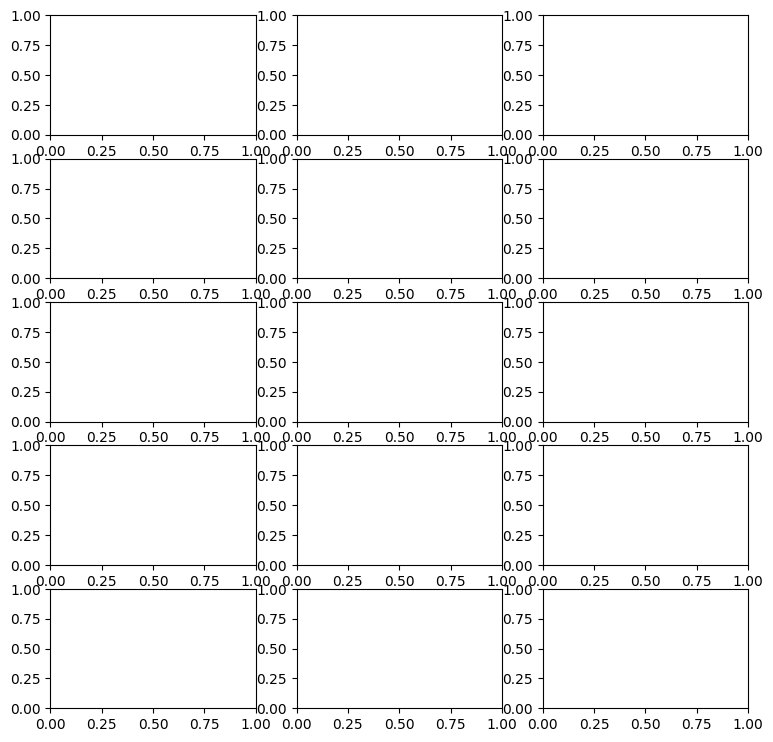

In [17]:
# 执行 t-SNE 可视化
# steps = [0, 1, 2, 3]
# steps = [1, 2, 3]
# step = [1, 2, 3]

steps = [1, 2, 3]
# methods = ['contra']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'contra']
methods = ["raw", "replay", "Coteaching", "cotta", "contra"]
# method = 'contra'
dataset_name = "cifar-10"
model_name = "cifar-resnet18"
noise_type = "symmetric"
noise_ratio = 0.2


# get_tsne(dataset_name, model_name, step, method, noise_type, noise_ratio)
plot_tsne(
    methods, steps, dataset_name, model_name, noise_type, noise_ratio, use_cache=False
)
# plot_tsne(methods, steps, dataset_name, model_name, noise_type, noise_ratio, use_cache=True)

# plot_tsne_contra(
#     dataset_name=dataset_name,
#     model_name=model_name,
#     steps=step,
#     methods=methods,
#     noise_type=noise_type,
#     noise_ratio=noise_ratio
# )

## TSNE - pet37

Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/raw/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/raw/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/raw/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/Coteaching/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/Coteaching/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/Coteaching/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra/tsne.npz
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/nr_0.2_nt_asymmetric_balanced/test_data.npy


/tmp/ipykernel_176788/1857373834.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


缓存tsne结果至：/nvme/szh/code/tta-mr/result_analysis/results_tsne/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra/tsne.npz


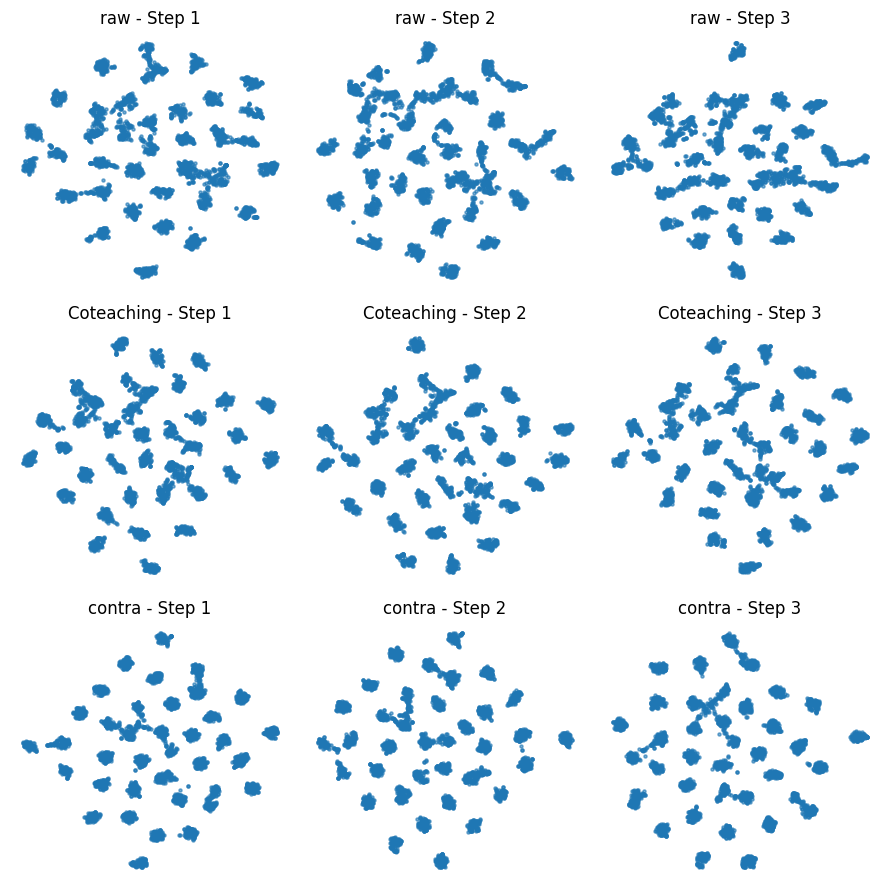

In [20]:
import torch
import numpy as np
import os
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

def load_model_and_data(
    dataset_name, model_name, step, method, noise_type, noise_ratio
):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 更改数据集为 pet-37
    dataset_name = "pet-37"  # 使用 Oxford-IIIT Pet 数据集
    
    # 构建数据集和模型的case
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    batch_size = 64
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        case,
        None,
        None,
        None,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
    )

    # 加载模型
    model_suffix = get_suffix(method, step)
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)

    # 生成正确的模型路径
    model_path = settings.get_ckpt_path(
        dataset_name,
        case,
        model_name,
        model_suffix=model_suffix,
        step=step,
        unique_name=method,
    )

    # 加载模型权重
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels

# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    handle.remove()

    # 拼接所有批次的嵌入
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

def get_cache_path_tsne(dataset_name, case, step, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_tsne/",
        dataset_name,
        case,
        f"step_{step}",
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")

# 绘制 t-SNE
def get_tsne(dataset_name, model_name, step, method, noise_type, noise_ratio):
    """
    绘制多个step的t-SNE结果，展示Contra方法在不同步骤的嵌入变化
    """
    model, dataloader, test_labels = load_model_and_data(
        dataset_name, model_name, step, method, noise_type, noise_ratio
    )
    embeddings = get_embeddings(model, dataloader)

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result

def plot_tsne(
    methods, steps, dataset_name, model_name, noise_type, noise_ratio, use_cache=False
):
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    plt.style.use("default")
    fig, axs = plt.subplots(len(methods), len(steps), figsize=(9, 9))
    tsne_results_all = {}
    for method in methods:
        tsne_resuls_step = {}
        for step in steps:
            cache_path = get_cache_path_tsne(
                dataset_name=dataset_name, case=case, step=step, unique_name=method
            )
            if use_cache:
                try:
                    data = np.load(cache_path)
                    tsne = data["tsne"]
                    print(f"读取缓存的tsne记录：{cache_path}")
                except FileNotFoundError:
                    print(
                        "未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False"
                    )
                    tsne = get_tsne(
                        dataset_name, model_name, step, method, noise_type, noise_ratio
                    )
                    np.savez(cache_path, tsne=tsne)
                    print(f"缓存tsne结果至：{cache_path}")
                tsne_resuls_step[step] = tsne
            else:
                tsne = get_tsne(
                    dataset_name, model_name, step, method, noise_type, noise_ratio
                )
                np.savez(cache_path, tsne=tsne)
                print(f"缓存tsne结果至：{cache_path}")
                tsne_resuls_step[step] = tsne

        tsne_results_all[method] = tsne_resuls_step

    # Plotting t-SNE results
    for method_idx, method in enumerate(methods):
        for step_idx, step in enumerate(steps):
            ax = axs[method_idx, step_idx]
            tsne_result = tsne_results_all.get(method, {}).get(step, None)
            if tsne_result is not None:
                ax.scatter(tsne_result[:, 0], tsne_result[:, 1], s=5, alpha=0.6)
                ax.set_title(f"{method} - Step {step}")
                ax.axis("off")
            else:
                ax.set_title(f"No data for {method} - Step {step}")
                ax.axis("off")

    plt.tight_layout()
    plt.show()

# 执行 t-SNE 可视化
steps = [1, 2, 3]
methods = ["raw", "Coteaching", "contra"]
dataset_name = "pet-37"  # 更改为 pet-37 数据集
model_name = "wideresnet50"  # 确保模型适配 pet-37 数据集
noise_type = "asymmetric"
noise_ratio = 0.2

plot_tsne(
    methods, steps, dataset_name, model_name, noise_type, noise_ratio, use_cache=False
)